**!!Запустите пожайлуста всю тетрадку, ибо большинство моделек я не успел дообучить (но они точно работают)!!**

# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2: сверточный классификатор.

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда. 



In [2]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    
    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    
    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3, 
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)
    
    return train_loader, val_loader, test_loader
    

In [3]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, 
                                                         transform_train=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Посмотрим на изображения:

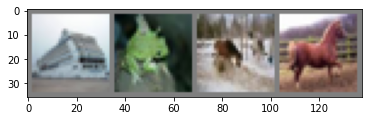

ship frog horse horse


In [4]:
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

**!!!Запустите пожайлуста всю тетрадку заново, ибо большинство моделек я не успел дообучить (но они точно работают)!!!**

In [5]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()
        #self.conv3 = nn.Conv2d(num_channels, kernel_size=1)
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=1)
        self.step_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=32)
        )
        self.step_2 = nn.Sequential(
            nn.AvgPool2d(kernel_size=8),
            nn.Flatten(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        relu = nn.ReLU()
        out = relu(self.step_1(x) + self.conv1_1(x))
        out = self.step_2(out)
        return out

In [6]:
net = BasicBlockNet()
net

BasicBlockNet(
  (conv1_1): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (step_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (step_2): Sequential(
    (0): AvgPool2d(kernel_size=8, stride=8, padding=0)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)

Проверим, что выход сети имеет корректную размерность:

In [7]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [9]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [10]:
from tqdm.notebook import tqdm

In [11]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()

    criterion = nn.CrossEntropyLoss()
    
    for data, target in loader:
        output = model(data)
        loss = criterion(output, target)
        loss_log.append(loss.item())
        
        y_pred = torch.argmax(output, 1)
        acc = (y_pred == target).sum() / len(target)
        acc_log.append(acc.item()) 
        
    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    criterion = nn.CrossEntropyLoss()
    
    for data, target in train_loader:
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        loss_log.append(loss.item())
        
        y_pred = torch.argmax(output, 1)
        acc = (y_pred == target).sum() / len(target)
        acc_log.append(acc.item()) 

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in tqdm(range(n_epochs)):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")
        
        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [12]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0
 train loss: 1.4444248418049577, train acc: 0.4885128297361203
 val loss: 1.2141590186890134, val acc: 0.569126773134191

Epoch 1
 train loss: 1.143781527522713, train acc: 0.6026010381456267
 val loss: 1.1607215214282909, val acc: 0.5943262412192973

Epoch 2
 train loss: 1.0356708270322252, train acc: 0.6380582397337151
 val loss: 1.052818712275079, val acc: 0.6365913120990104

Epoch 3
 train loss: 0.9793335636311519, train acc: 0.6595676090207353
 val loss: 1.0260854398950618, val acc: 0.646875

Epoch 4
 train loss: 0.9429835909245436, train acc: 0.6716015930585495
 val loss: 0.9505378862644763, val acc: 0.6690159574468085

Epoch 5
 train loss: 0.9158675303406864, train acc: 0.6818808761767539
 val loss: 0.9448350191116333, val acc: 0.6778812055892133

Epoch 6
 train loss: 0.8872876835261664, train acc: 0.6883691890366117
 val loss: 1.019775681292757, val acc: 0.6572695034615537

Epoch 7
 train loss: 0.8687317593115121, train acc: 0.697762960271818
 val loss: 0.93966796474253

Посчитайте точность на тестовой выборке:

In [13]:
test_loss, test_acc = test(net, test_loader)

In [14]:
test_loss

0.8706478932101256

In [15]:
test_acc

0.7026273885350318

Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

In [72]:
def plot_stats(
    train_loss,
    valid_loss,
    train_accuracy,
    valid_accuracy,
    title: str
):
    plt.figure(figsize=(13, 7))

    plt.title(title + ' loss')

    n = (len(train_loss) // len(valid_loss))
    valid_loss_drow = np.reshape(np.array(valid_loss*n), (n, len(valid_loss)))
    valid_loss_drow = np.reshape(valid_loss_drow, (1, len(train_loss)), order='F')[0]

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss_drow, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(13, 7))

    plt.title(title + ' accuracy')

    n = (len(train_accuracy) // len(valid_accuracy))
    valid_accuracy_drow = np.reshape(np.array(valid_accuracy*n), (n, len(valid_accuracy)))
    valid_accuracy_drow = np.reshape(valid_accuracy_drow, (1, len(train_accuracy)), order='F')[0]

    plt.plot(train_accuracy)
    plt.plot(valid_accuracy_drow)
    plt.grid()

    plt.show()

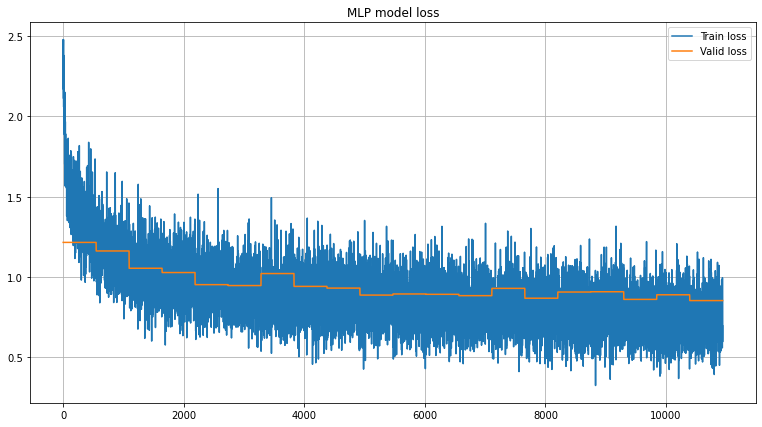

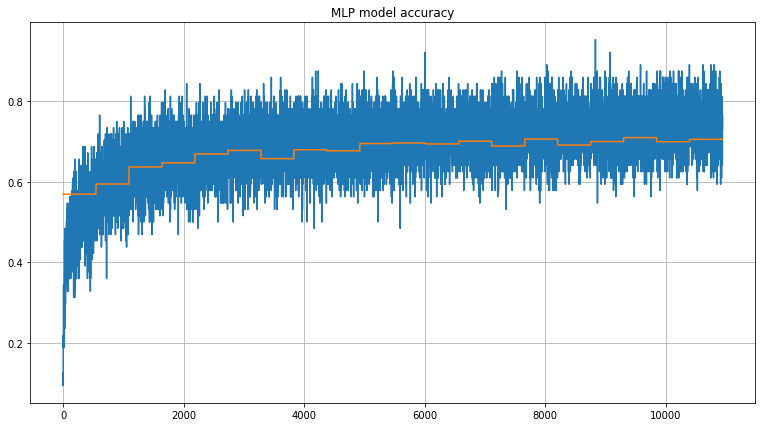

In [73]:
plot_stats(train_loss_log, val_loss_log, train_acc_log, val_acc_log, 'MLP model')

Так как функции потерь и точности классификации на обучающей выборке считаются по каждому батчу, а на валидационной же они считаются по всей выборке раз в эпоху, валифационные графиуи получились кусочно постоянными (дублировал каждле из значений валидацинной выборки n раз подряд, для корректного построения графиков)

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [23]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0
 train loss: 1.4741270825457529, train acc: 0.474316074708698
 val loss: 1.293685662239156, val acc: 0.5469193263256803

Epoch 1
 train loss: 1.1650264171621263, train acc: 0.5889715004228805
 val loss: 1.1424294081140072, val acc: 0.6064051417594261

Epoch 2
 train loss: 1.0717531779348524, train acc: 0.628154380992736
 val loss: 1.1044049851437832, val acc: 0.6158244680851064

Epoch 3
 train loss: 1.0123356331201097, train acc: 0.6481987790390168
 val loss: 1.0091895237882087, val acc: 0.6514627659574468

Epoch 4
 train loss: 0.970197770996547, train acc: 0.6633177722175989
 val loss: 1.0004458797738907, val acc: 0.652216311972192

Epoch 5
 train loss: 0.938771998533601, train acc: 0.676347447160829
 val loss: 0.9759729580676302, val acc: 0.6654476949509154

Epoch 6
 train loss: 0.9147716487129602, train acc: 0.6790611126087266
 val loss: 0.9438005021277894, val acc: 0.6765514183551707

Epoch 7
 train loss: 0.9002446305054416, train acc: 0.6874102246172903
 val loss: 0.889756

Посчитайте точность на тестовой выборке:

In [24]:
test_loss, test_acc = test(net, test_loader)
test_acc

0.7123805732484076

**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [25]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0
 train loss: 1.827539084380462, train acc: 0.3602482697754499
 val loss: 1.5986442728245511, val acc: 0.4436613474754577

Epoch 1
 train loss: 1.519602906333463, train acc: 0.47028434314719064
 val loss: 1.4421540336405978, val acc: 0.4874113474754577

Epoch 2
 train loss: 1.3957429307034508, train acc: 0.5101364586209466
 val loss: 1.3486738783247927, val acc: 0.5167553191489361

Epoch 3
 train loss: 1.3199637622676341, train acc: 0.5363100678872801
 val loss: 1.2819347706246884, val acc: 0.5469858155605641

Epoch 4
 train loss: 1.2658991073777515, train acc: 0.5560524940926589
 val loss: 1.230294255753781, val acc: 0.5688608155605641

Epoch 5
 train loss: 1.2199924564230813, train acc: 0.57260381303714
 val loss: 1.2247850676800343, val acc: 0.5698359929500743

Epoch 6
 train loss: 1.1805418665491902, train acc: 0.589734591230396
 val loss: 1.167050268802237, val acc: 0.5886968085106383

Epoch 7
 train loss: 1.1434214850666318, train acc: 0.6011564703266625
 val loss: 1.12986

In [26]:
test_loss, test_acc = test(net, test_loader)
test_acc

0.6704816878980892

**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

**Запустите пожайлуста всю тетрадку, ибо большинство моделек я не успел дообучить (но они точно работают)**

на каждом шаже домножает lr на gamma


In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, gamma=0.8)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

In [ ]:
test_loss, test_acc = test(net, test_loader)
test_acc

каждые ster_size (в данном случае 5) домножает lr на gamma

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

In [ ]:
test_loss, test_acc = test(net, test_loader)
test_acc

Your answers here:

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

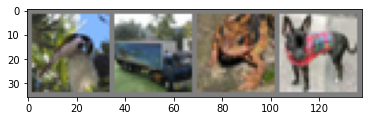

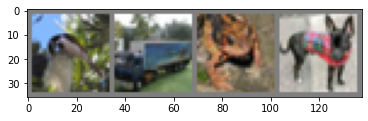

In [74]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [76]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

Посчитайте точность на тестовой выборке:

In [ ]:
test_loss, test_acc = test(net, test_loader)
test_acc

**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

**!!Запустите пожайлуста всю тетрадку, ибо большинство моделек я не успел дообучить (но они точно работают)!!**

Переворачивает картинку + обрезает её, оставляя центральный квадрат 23x23

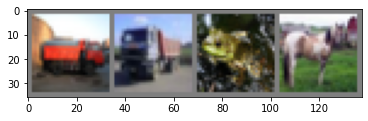

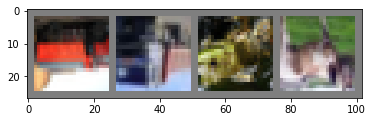

In [78]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

tr = torchvision.transforms.CenterCrop(23) # обркзает картинку
flip = torchvision.transforms.RandomVerticalFlip(0.5) # переворачивает картинку

imshow(torchvision.utils.make_grid(flip(tr(images[:4]))))

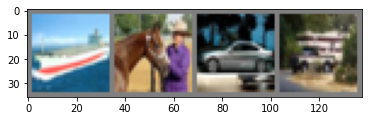

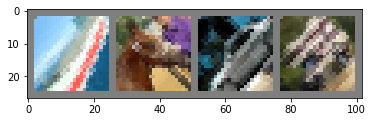

In [79]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

tr = torchvision.transforms.CenterCrop(23) # обрезает картинку
rot = torchvision.transforms.RandomRotation([20, 50]) # поворот картинки на угол в диапозоне [20, 50]

imshow(torchvision.utils.make_grid(tr(rot(images[:4]))))

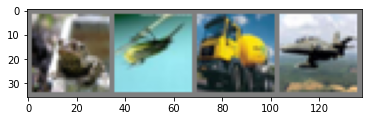

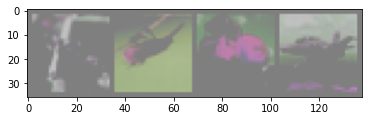

In [102]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

tr = torchvision.transforms.ColorJitter(brightness=.5, hue=.4) # изменяут яркость и оттенок изображения
rot = torchvision.transforms.RandomRotation([20, 50]) # поворот картинки на угол в диапозоне [20, 50]

imshow(torchvision.utils.make_grid(tr((images[:4]))))

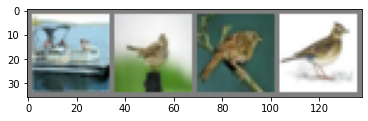

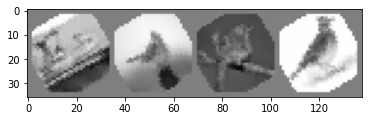

In [82]:

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

tr = torchvision.transforms.Grayscale() # преовывает изображение в оттенки серого
rot = torchvision.transforms.RandomRotation([20, 50]) # поворот картинки на угол в диапозоне [20, 50]

imshow(torchvision.utils.make_grid(tr(rot(images[:4]))))

обучение с отражением по вертикали + отражение по горизонтали

In [79]:
transform = transforms.Compose(
        [torchvision.transforms.RandomVerticalFlip(),
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

Обучаем с поворотом на угол

In [86]:
transform = transforms.Compose(
        [torchvision.transforms.RandomRotation([20, 50]), # поворот картинки на угол в диапозоне [20, 50]
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
test_loss, test_acc = test(net, test_loader)
test_acc

обучение с измением яркости и оттенка изображения

In [87]:
transform = transforms.Compose(
        [torchvision.transforms.ColorJitter(brightness=.5, hue=.4),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0
 train loss: 1.7184213606923329, train acc: 0.3897476495401951
 val loss: 1.5294592294287175, val acc: 0.45031028364567044



KeyboardInterrupt: ignored

In [ ]:
test_loss, test_acc = test(net, test_loader)
test_acc

обучение с отражением по горизонтали

In [95]:
transform = transforms.Compose(
        [torchvision.transforms.RandomVerticalFlip(0.5),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
test_loss, test_acc = test(net, test_loader)
test_acc

обучение с поворотом + отражение картинки по горизонтали + с измением яркости и оттенка изображения + отражение по вертикали 

In [94]:
transform = transforms.Compose(
        [torchvision.transforms.RandomVerticalFlip(0.5),
         transforms.RandomHorizontalFlip(),
         torchvision.transforms.RandomRotation([20, 50]),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
test_loss, test_acc = test(net, test_loader)
test_acc

Your answers here:

## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

In [ ]:
# <your code here>